In [48]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Reshape, concatenate
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import numpy.matlib
from PIL import Image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.special import softmax
import bottleneck


In [49]:
IMG_SIZE = 224
NUM_CLASSES = 10
# the first 2 dimensions should be equal to width of the output from the bottleneck expand ReLU at the (4,1) and (5,3) respectively.
# the dimensions after the second one are determined by the convolutions written inside the SSD (conv1_2, conv2_2, conv3_3, conv4_2)
layerWidths = [28,14,7]
numBoxes = [3,3,3]
assert len(numBoxes) == len(layerWidths) # numBoxes for each layer and each layer has a specific width
outputChannels = NUM_CLASSES + 1 + 4 # 10 classes + background + cx,cy,h,w
assert outputChannels - NUM_CLASSES == 5

In [50]:
MinScale = .1 # Min and Max scale given as percentage
MaxScale = 1.5
scales = [ MinScale + x/len(layerWidths) * (MaxScale-MinScale) for x in range(len(layerWidths)) ]
scales = scales[::-1] # reversing the order because the layerWidths go from high to low (lower to higher resoltuion)
asp = [0.5,1.0,1.5]
asp1 = [x**0.5 for x in asp]
asp2 = [1/x for x in asp1]
scales

In [51]:
# should be equal to the 1st dimension in the output layer of the SSD model
BOXES = sum([a*a*b for a,b in zip(layerWidths,numBoxes)])
centres = np.zeros((BOXES,2))
hw = np.zeros((BOXES,2))
boxes = np.zeros((BOXES,4))
BOXES

3087

In [52]:
class Model(tf.keras.Model):
    def __init__(self, numBoxes=[3,3,3,3,3,3,3], layerWidth=[56,28,14,7,4,2,1], k = NUM_CLASSES + 5):
        super(Model, self).__init__()
        self.classes = k
        self.featureMaps = 3
        
        base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
        self.base = tf.keras.Model(inputs=base_model.input, outputs=[base_model.get_layer(layer).output for layer in [
            'block_6_expand_relu',  # 28x28 * IMG_SIZE / 224
            'block_13_expand_relu', # 14x14 * IMG_SIZE / 224
            'block_16_project'      # 7x7 * IMG_SIZE / 224
        ]])
        
        self.base.trainable = False
        
        self.numBoxes = numBoxes
        self.layerWidth = layerWidth
            
        self.conv = []
        self.reshape = []
        for i in range(self.featureMaps):
            self.conv.append(Conv2D(self.numBoxes[i]*self.classes,3,padding='same',name='Classification_'+str(i)))
            self.reshape.append(Reshape((self.layerWidth[i]* self.layerWidth[i] * self.numBoxes[i],self.classes),name='Reshape_classification_'+str(i)))

        self.optimizer = tf.keras.optimizers.Adam()
        
    def freeze_base(self):
        self.base.trainable = False
        return self
    
    def compute_loss(self, class_scores, box_preds, gt_labels, gt_boxes):
        # Compute classification loss
        cls_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(gt_labels, class_scores)

        # Compute regression loss (Smooth L1 loss)
        box_loss = tf.keras.losses.Huber()(gt_boxes, box_preds)

        # Total loss
        total_loss = cls_loss + box_loss
        return total_loss
    
    def call(self, inputs):
        x_ = self.base(inputs)
        
        classifiers = []
        for i in range(self.featureMaps):
            x = self.conv[i](x_[i])
            x = self.reshape[i](x)
            classifiers.append(x)
            
        x = concatenate(classifiers, axis=-2, name='concatenate')
        return x
    
    @tf.function(input_signature=[
        tf.TensorSpec([None, IMG_SIZE, IMG_SIZE, 3], tf.float32),
        tf.TensorSpec([None, BOXES, 5], tf.float32),
    ])
    def train(self, images, gt):
        gt_labels = gt[:,:,0]
        gt_boxes = gt[:,:,-4:]
        with tf.GradientTape() as tape:
            preds = self(images, training=True)
            class_scores = preds[:,:,:-4]
            box_preds = preds[:, :, -4:]
            loss = self.compute_loss(class_scores, box_preds, gt_labels, gt_boxes)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {'loss' : loss}
    
    @tf.function(input_signature=[tf.TensorSpec([None, IMG_SIZE, IMG_SIZE, 3], tf.float32)])
    def infer(self, images):
        return self(images, training=False)
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def save(self, checkpoint_path):
        tensor_names = [v.name for v in self.trainable_variables]
        tensors_to_save = [v.read_value() for v in self.trainable_variables]
        tf.raw_ops.Save(
            filename=checkpoint_path, tensor_names=tensor_names,
            data=tensors_to_save, name='save')
        return {
            "checkpoint_path": checkpoint_path
        }

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def restore(self, checkpoint_path):
        restored_tensors = {}
        for var in self.trainable_variables:
            restored = tf.raw_ops.Restore(
                file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
                name='restore')
            var.assign(restored)
            restored_tensors[var.name] = restored
        return restored_tensors
    

In [53]:
model = Model(numBoxes=numBoxes, layerWidth=layerWidths, k=outputChannels)

In [54]:
# calculating the default box centres and height, width
idx = 0

for gridSize, numBox, scale in zip(layerWidths,numBoxes,scales):
    step_size = IMG_SIZE*1.0/gridSize
    for i in range(gridSize):
        for j in range(gridSize):
            pos = idx + (i*gridSize+j) * numBox
            # centre is the same for all aspect ratios(=numBox)
            centres[ pos : pos + numBox , :] = i*step_size + step_size/2, j*step_size + step_size/2
            # height and width vary according to the scale and aspect ratio
            # zip asepct ratios and then scale them by the scaling factor
            hw[ pos : pos + numBox , :] = np.multiply(gridSize*scale, np.squeeze(np.dstack([asp1,asp2]),axis=0))[:numBox,:]

    idx += gridSize*gridSize*numBox

In [55]:
# (x,y) co-ordinates of top left and bottom right
# This actually is not used anywhere. centres[] and hw[] are a good enough substitute
boxes[:,0] = centres[:,0] - hw[:,0]/2
boxes[:,1] = centres[:,1] - hw[:,1]/2
boxes[:,2] = centres[:,0] + hw[:,0]/2
boxes[:,3] = centres[:,1] + hw[:,1]/2

In [56]:
def IoU(box1, box2):
    box1 = box1.astype(np.float64)
    box2 = box2.astype(np.float64)
    # find the left and right co-ordinates of the edges. Min should be less than Max for non zero overlap
    xmin = np.maximum(box1[:,0],box2[:,0])
    xmax = np.minimum(box1[:,2],box2[:,2])
    ymin = np.maximum(box1[:,1],box2[:,1])
    ymax = np.minimum(box1[:,3],box2[:,3])

    intersection = np.abs(np.maximum(xmax-xmin,0) * np.maximum(ymax-ymin,0))
    boxArea1 = np.abs((box1[:,2] - box1[:,0]) * (box1[:,3] - box1[:,1]))
    boxArea2 = np.abs((box2[:,2] - box2[:,0]) * (box2[:,3] - box2[:,1]))
    unionArea = boxArea1 + boxArea2 - intersection
    assert (unionArea > 0).all()
    iou = intersection / unionArea

    return iou

In [57]:
def bestIoU(searchBox):
    iou_values = IoU(np.matlib.repmat(searchBox, BOXES, 1), boxes)
    print(f"IOU values: {iou_values}")
    return np.argwhere(iou_values > 0.5)

In [58]:
TRAINSIZE = 600
TESTSIZE = 100

In [59]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[:TRAINSIZE , : , :]
y_train = y_train[:TRAINSIZE]
x_test = x_test[:TESTSIZE , : , :]
y_test = y_test[:TESTSIZE]

In [60]:
# take mnist x and y pairs and convert to input, output pairs for the MobileNetv2+SSD model
def convert(x,y):
    MNIST_SIZE = x.shape[-1]
    print(x.shape)
    # create a 2D array of top left corners for the mnist image to be placed
    corner = np.random.randint(IMG_SIZE - MNIST_SIZE, size=(x.shape[0],2))
    # create a blank canvas for the input with the required dimension
    input = np.zeros((x.shape[0], IMG_SIZE, IMG_SIZE, 3))

    # replacing a part by RGB version of MNIST
    for i in range(x.shape[0]):
        lx = int(corner[i,0])
        ly = int(corner[i,1])
        input[i,lx:lx + MNIST_SIZE, ly:ly+MNIST_SIZE,:] = np.repeat(np.expand_dims(np.array(x[i,:,:]),axis=-1),3,axis=-1)

    # for each default box, there are 5 values: class number and delta cx,cy,h,w
    output = np.zeros((y.shape[0],BOXES,1+4))
    output[:,:,0] = NUM_CLASSES # defaulting class labels for all boxes to background initially
    for i in range(x.shape[0]):
        bbox = np.zeros(4)
        bbox[:2] = corner[i]
        bbox[2:] = corner[i] + (MNIST_SIZE, MNIST_SIZE)
        print(f"BBox: {bbox}")  # Debug: Print BBox
        box_idx = bestIoU(bbox).astype(np.uint16)
        print(f"Box indices with IoU > threshold: {box_idx}")  # Debug: Print indices
        if len(box_idx) == 0:
            print(f"No boxes found with IoU > threshold for sample {i}")  # Debug: No boxes found
            continue
        output[i, box_idx, 0] = y[i]
        output[i, box_idx, 1] = (bbox[0] + bbox[2]) / 2.0 - centres[box_idx, 0]
        output[i, box_idx, 2] = (bbox[1] + bbox[3]) / 2.0 - centres[box_idx, 1]
        output[i, box_idx, 3] = MNIST_SIZE - hw[box_idx, 0]
        output[i, box_idx, 4] = MNIST_SIZE - hw[box_idx, 1]

    return input, output

In [61]:
test_x, test_y = convert(x_test,y_test)
train_x, train_y = convert(x_train,y_train)

# for i in range(TRAINSIZE):
#     data = Image.fromarray(train_x[i].astype(np.uint8))
#     data.save('mnist/images/' + str(i) + ".png")
#     np.savetxt('mnist/labels/' + str(i) + ".txt", train_y[i], newline="\n", fmt='%d')

test_x = (test_x.astype(np.float32) - 127.5) / 127.5
test_y = test_y.astype(np.float32)
train_x = (train_x.astype(np.float32) - 127.5) / 127.5
train_y = train_y.astype(np.float32)

(100, 28, 28)
BBox: [  6. 186.  34. 214.]
IOU values: [0. 0. 0. ... 0. 0. 0.]
Box indices with IoU > threshold: [[240]
 [241]
 [242]
 [243]
 [244]
 [245]]
BBox: [ 46. 129.  74. 157.]
IOU values: [0. 0. 0. ... 0. 0. 0.]
Box indices with IoU > threshold: [[557]
 [639]
 [640]
 [641]
 [642]
 [643]
 [644]
 [725]]
BBox: [141. 105. 169. 133.]
IOU values: [0. 0. 0. ... 0. 0. 0.]
Box indices with IoU > threshold: [[1555]
 [1556]
 [1638]
 [1639]
 [1640]
 [1641]
 [1642]
 [1643]]
BBox: [126.  34. 154.  62.]
IOU values: [0. 0. 0. ... 0. 0. 0.]
Box indices with IoU > threshold: [[1443]
 [1444]
 [1445]
 [1446]
 [1447]
 [1448]]
BBox: [ 49.  89.  77. 117.]
IOU values: [0. 0. 0. ... 0. 0. 0.]
Box indices with IoU > threshold: [[624]
 [625]
 [626]
 [627]
 [628]
 [629]
 [709]
 [710]
 [712]
 [713]]
BBox: [ 32. 141.  60. 169.]
IOU values: [0. 0. 0. ... 0. 0. 0.]
Box indices with IoU > threshold: [[474]
 [475]
 [477]
 [478]
 [479]
 [562]
 [563]]
BBox: [ 63.  91.  91. 119.]
IOU values: [0. 0. 0. ... 0. 0. 0.]

Number of boxes with IoU > threshold (0.5): 8
Green box: ground truth. Red box: default boxes with IoU < threshold (0.5)


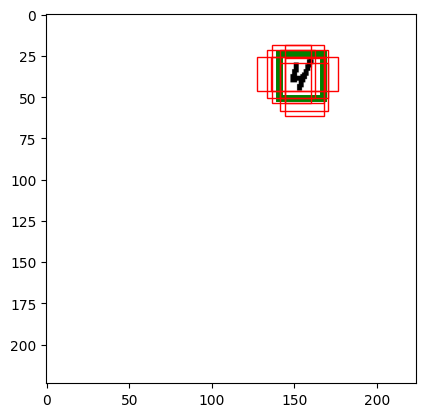

In [62]:
r = np.random.randint(0,train_x.shape[0])
img = train_x[r,:,:,:].copy()
img_y = train_y[r]

im = np.array(Image.fromarray(img.astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

# find all boxes where class label is not background
idx = np.argwhere(img_y[:,0] != NUM_CLASSES)[:,0]
print('Number of boxes with IoU > threshold (0.5):',idx.shape[0])
print('Green box: ground truth. Red box: default boxes with IoU < threshold (0.5)')

#calculating the ground truth bounding boxes
gt = np.zeros(4,dtype=np.uint16)
gt[:2] = (img_y[idx[0],1:3] + centres[idx[0],:2])
gt[2:] = (img_y[idx[0],3:] + hw[idx[0],:])

# for some reason, x and y are inverted
rect = patches.Rectangle((gt[1]-gt[3]/2,gt[0]-gt[2]/2),gt[3],gt[2],linewidth=5,edgecolor='g',facecolor='none')
ax.add_patch(rect)

# showing all the boxes with IoU > 0.5
for i in idx:
    rect = patches.Rectangle((centres[i][1]-hw[i,1]/2,centres[i][0]-hw[i,0]/2),hw[i,1],hw[i,0],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()

In [63]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3087, 5), dtype=tf.float32, name=None))
(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3087, 5), dtype=tf.float32, name=None))


In [64]:
NUM_EPOCHS = 10
BATCH_SIZE = 32
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])

train_ds = train_dataset.batch(BATCH_SIZE)
for i in range(NUM_EPOCHS):
    for x, y in train_ds:
        result = model.train(x, y)
        
    losses[i] = result['loss']
    print(f"Finished {i+1} epochs")
    print(f"  loss: {losses[i]:.3f}")

Finished 1 epochs
  loss: 0.081
Finished 2 epochs
  loss: 0.034
Finished 3 epochs
  loss: 0.022
Finished 4 epochs
  loss: 0.019
Finished 5 epochs
  loss: 0.016
Finished 6 epochs
  loss: 0.015
Finished 7 epochs
  loss: 0.014
Finished 8 epochs
  loss: 0.013
Finished 9 epochs
  loss: 0.013
Finished 10 epochs
  loss: 0.012


In [65]:
model.save('tmp/model.ckpt')

{'checkpoint_path': <tf.Tensor: shape=(), dtype=string, numpy=b'tmp/model.ckpt'>}

In [66]:
SAVED_MODEL_DIR = "saved_model"

tf.saved_model.save(
    model,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            model.train.get_concrete_function(),
        'infer':
            model.infer.get_concrete_function(),
        'save':
            model.save.get_concrete_function(),
        'restore':
            model.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [67]:
tflite_model_path = "model.tflite"
with open(tflite_model_path, "wb") as file:
    file.write(tflite_model)

In [68]:
model.restore('tmp/model.ckpt')

{'model_4/Classification_0/kernel:0': <tf.Tensor: shape=(3, 3, 192, 45), dtype=float32, numpy=
 array([[[[-0.05343378, -0.04259083, -0.01937467, ...,  0.03864368,
            0.01640514,  0.02292884],
          [-0.05042508, -0.06294594, -0.04145951, ...,  0.03687508,
           -0.01527764, -0.02439376],
          [-0.03199578,  0.09714512, -0.04359083, ..., -0.0033529 ,
            0.03077117,  0.04176926],
          ...,
          [-0.02083834,  0.03523739,  0.02275331, ..., -0.01802266,
            0.04290135, -0.04086348],
          [-0.04512413,  0.00097799, -0.00774899, ...,  0.01324404,
           -0.01022756, -0.00548602],
          [-0.05167878, -0.01512524, -0.05048965, ..., -0.00332415,
           -0.007146  , -0.03568171]],
 
         [[-0.03705228, -0.05042589,  0.01083983, ...,  0.02711044,
           -0.03357879,  0.01279059],
          [-0.02050971, -0.03377354, -0.00628494, ...,  0.0366847 ,
            0.01123526, -0.02412363],
          [-0.05863397,  0.03055101, -0

In [69]:
X, Y = convert(x_test, y_test)

(100, 28, 28)
BBox: [11.  3. 39. 31.]
IOU values: [0.04465756 0.07670055 0.09254398 ... 0.         0.         0.        ]
Box indices with IoU > threshold: [[172]
 [173]
 [175]
 [176]
 [255]
 [256]
 [257]
 [258]
 [259]
 [260]]
BBox: [158.  56. 186.  84.]
IOU values: [0. 0. 0. ... 0. 0. 0.]
Box indices with IoU > threshold: [[1705]
 [1706]
 [1788]
 [1789]
 [1790]
 [1791]
 [1792]
 [1793]
 [1873]
 [1874]]
BBox: [117.  70. 145.  98.]
IOU values: [0. 0. 0. ... 0. 0. 0.]
Box indices with IoU > threshold: [[1291]
 [1292]
 [1371]
 [1372]
 [1374]
 [1375]
 [1376]
 [1377]
 [1378]
 [1459]]
BBox: [ 11. 192.  39. 220.]
IOU values: [0. 0. 0. ... 0. 0. 0.]
Box indices with IoU > threshold: [[244]
 [245]
 [327]
 [328]
 [329]
 [330]
 [331]
 [332]]
BBox: [ 12. 126.  40. 154.]
IOU values: [0. 0. 0. ... 0. 0. 0.]
Box indices with IoU > threshold: [[220]
 [221]
 [300]
 [301]
 [303]
 [304]
 [305]
 [306]
 [307]]
BBox: [ 87. 195. 115. 223.]
IOU values: [0. 0. 0. ... 0. 0. 0.]
Box indices with IoU > threshold: 

In [70]:
y_pred = model.infer(X)
y_pred.shape

TensorShape([100, 3087, 15])

In [71]:
OBJperCLASS = 10 # get the top 10 results for each class
# get the confidence scores (with class values) and delta for the boxes. For each class, the top 10 values are used
def infer(Y):
    # classes are actually the index into the default boxes
    classes = np.zeros((OBJperCLASS,outputChannels-4),dtype=np.uint16)
    conf = np.zeros((OBJperCLASS,outputChannels-4))
    delta = np.zeros((OBJperCLASS,outputChannels-4,4))
    class_predictions = softmax(Y[:,:outputChannels-4],axis=1)
    for i in range(outputChannels-4):
        classes[:,i] = bottleneck.argpartition(class_predictions[:,i],BOXES-1-10,axis=-1)[-OBJperCLASS:]
        conf[:,i] = class_predictions[classes[:,i],i]
        delta_tmp = []
        for j in range(len(classes[:,i])):
            delta_tmp.append(Y[classes[:,i][j],outputChannels-4:])
        delta[:,i] = delta_tmp
    # print(classes)
    # print(delta)
    # print(class_predictions)
    return conf,classes, delta

# generate bounding boxes from the inferred outputs
def Bbox(confidence,box_idx,delta):
    #delta contains delta(cx,cy,h,w)
    bbox_centre = np.zeros((OBJperCLASS,outputChannels-4,2))
    bbox_hw = np.zeros((OBJperCLASS,outputChannels-4,2))
    for i in range(OBJperCLASS):
        bbox_centre[i,:,0] = centres[box_idx[i]][:,0]+delta[i,:,0]
        bbox_centre[i,:,1] = centres[box_idx[i]][:,1]+delta[i,:,1]
        bbox_hw[i,:,0] = hw[box_idx[i]][:,0] + delta[i,:,2]
        bbox_hw[i,:,1] = hw[box_idx[i]][:,1]+delta[i,:,3]
    return bbox_centre,bbox_hw

----
4
----
4: Confidence-0.11696570366621017		Centre-[129.222157    76.39168939] Height,Width-[27.73665028 28.30480712]
4: Confidence-0.09897840023040771		Centre-[118.91008735  84.01673194] Height,Width-[33.5820414  24.56554422]
4: Confidence-0.48553362488746643		Centre-[122.95947981  77.50075746] Height,Width-[27.24976354 26.60971707]
4: Confidence-0.49965184926986694		Centre-[124.87777692  81.80779505] Height,Width-[29.34985777 28.28557102]
4: Confidence-0.14469845592975616		Centre-[123.03676522  89.59425569] Height,Width-[23.39885922 37.68879596]
4: Confidence-0.14052195847034454		Centre-[116.48408702  75.63799971] Height,Width-[28.81205293 27.89664036]
4: Confidence-0.13434341549873352		Centre-[126.12980938  77.97468674] Height,Width-[27.11627044 27.91015348]
4: Confidence-0.9410936832427979		Centre-[124.85119408  78.95202756] Height,Width-[25.87341877 29.46047394]
4: Confidence-0.4925287663936615		Centre-[123.71820626  79.48471117] Height,Width-[27.38489085 27.66962987]
4: Confid

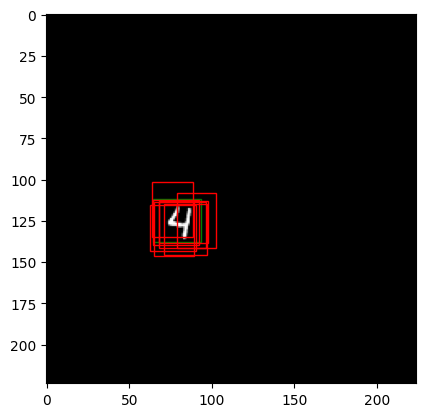

In [72]:
r = np.random.randint(TESTSIZE)

# top 10 predictions for each class
confidence, box_idx, delta = infer(y_pred[r])
bbox_centre,bbox_hw = Bbox(confidence, box_idx, delta)

im = np.array(Image.fromarray(X[r].astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

for i in range(outputChannels-4):
    # skipping backgrounds
    if i == NUM_CLASSES:
        continue
    color = 'r'
    # if a class is mentioned in the ground truth, color the boxes green
    if i in Y[r,:,0]:
        color = 'g'
        print('----')
        print(i)
        print('----')
  
  # skip all the classes which have low confidence values
    if (confidence[:,i] > 0.5).any() or i in Y[r,:,0]:
        for k in range(OBJperCLASS):
            print("{}: Confidence-{}\t\tCentre-{} Height,Width-{}".format(i,confidence[k,i],bbox_centre[k,i],bbox_hw[k,i]))
            
            # draw bounding box only if confidence scores are high
            if confidence[k,i] < 0.5:
                continue
            x = bbox_centre[k,i,0] - bbox_hw[k,i,0]/2
            y = bbox_centre[k,i,1] - bbox_hw[k,i,1]/2
            rect = patches.Rectangle((y,x),bbox_hw[k,i,1],bbox_hw[k,i,0],linewidth=1,edgecolor=color,facecolor='none')
            ax.add_patch(rect)

plt.show()